In [1]:
import torch
# torch.set_num_threads(1)
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 5

In [3]:
def get_task():
    return mfl.tasks.get_svm_regression_fns(
        data_path="w8a",
        num_clients=NUM_CLIENTS,
        batch_size=-1,
    )

In [4]:
GD_STEPS = 100

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma_multiplier=10,
)

GD_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, GD_STEPS)

100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


In [5]:
MARINA_EDEN_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.EdenUnbiasedCompressor(master_fn.size(), bits=1.5) for _ in range(NUM_CLIENTS)],
    p=0.01,
    gamma_multiplier=10,
)

MARINA_EDEN_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, MARINA_EDEN_STEPS)

100%|██████████| 1000/1000 [01:09<00:00, 14.44it/s]


In [6]:
MARINA_RAND_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.RandKUnbiasedCompressor(master_fn.size(), p=1/32*1.5) for _ in range(NUM_CLIENTS)],
    p=0.01,
    gamma_multiplier=10,
    seed=1,
)

MARINA_RAND_METRICS = mfl.algorithms.run_algorithm_with_threads(master, clients, MARINA_RAND_STEPS)

100%|██████████| 1000/1000 [00:19<00:00, 50.56it/s]


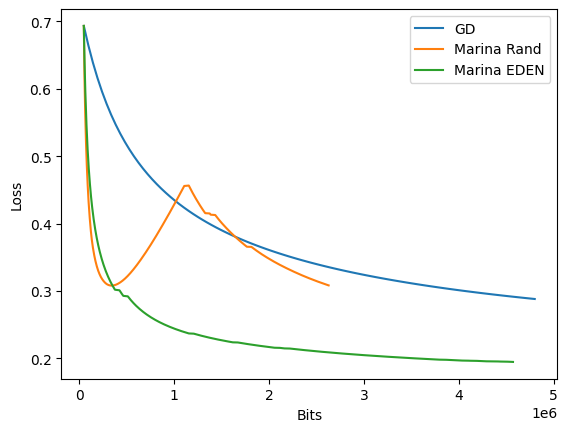

In [7]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_RAND_METRICS], [metrics.value for metrics in MARINA_RAND_METRICS], label="Marina Rand")
plt.plot([metrics.total_bits_received for metrics in MARINA_EDEN_METRICS], [metrics.value for metrics in MARINA_EDEN_METRICS], label="Marina EDEN")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

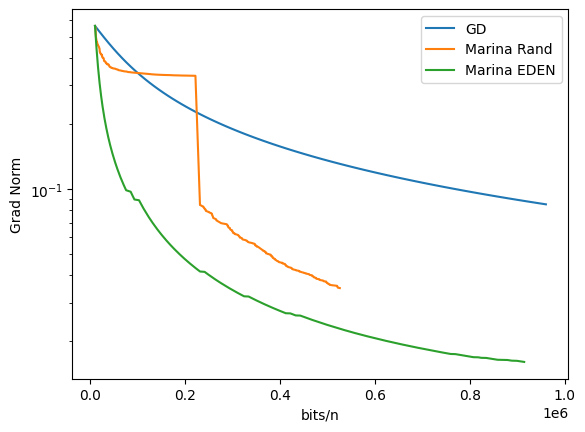

In [8]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in MARINA_RAND_METRICS], [metrics.grad_norm for metrics in MARINA_RAND_METRICS], label="Marina Rand")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in MARINA_EDEN_METRICS], [metrics.grad_norm for metrics in MARINA_EDEN_METRICS], label="Marina EDEN")
plt.yscale("log")

plt.xlabel("bits/n")
plt.ylabel("Grad Norm")
plt.legend()